In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from torchvision.models import ResNet18_Weights
from torchvision.models import resnet18
import cv2
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

In [16]:
train_data_path = 'data/train'
test_data_path = 'data/test'

In [17]:
hotdog_path = os.path.join(train_data_path, 'hotdog')
not_hotdog_path = os.path.join(train_data_path, 'nothotdog')

In [18]:
hotdog_images = []
not_hotdog_images = []
for image_path in os.listdir(hotdog_path):
    hotdog_images.append(cv2.cvtColor(cv2.imread(os.path.join(hotdog_path, image_path)), cv2.COLOR_BGR2RGB))
for image_path in os.listdir(not_hotdog_path):
    not_hotdog_images.append(cv2.cvtColor(cv2.imread(os.path.join(not_hotdog_path, image_path)), cv2.COLOR_BGR2RGB))

In [19]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(dtype=torch.float32),
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    #transforms.ColorJitter(brightness=0.05, hue=0.3),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(dtype=torch.float32),
    transforms.Resize(256),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [20]:
hotdog_train, hotdog_val = train_test_split(hotdog_images, test_size=0.2, random_state=42)
not_hotdog_train, not_hotdog_val = train_test_split(not_hotdog_images, test_size=0.2, random_state=42)
train_data = [(transform_train(image), 1) for image in hotdog_train]
val_data = [(transform_val(image), 1) for image in hotdog_val]
train_data.extend([(transform_train(image), 0) for image in not_hotdog_train])
val_data.extend([(transform_val(image), 0) for image in not_hotdog_val])

c:\Users\ivan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [21]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

In [22]:
model = resnet18(weights=ResNet18_Weights.DEFAULT) #Pretrained ResNet18
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2) #Changing the number of outputs to 2

device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
device

'cuda:0'

!!!


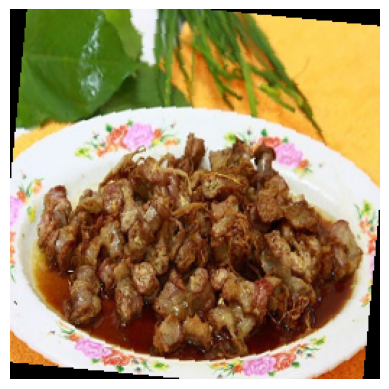

tensor(0)


In [23]:
i = 0
for i in range(1):
    print('!!!')
    i = 0
    for images, label in train_loader:
        first_image = images[0].numpy()
        plt.imshow(np.transpose(first_image, (1, 2, 0)))
        plt.axis('off')
        plt.show()
        print(label[0])
        if i >= 0:
            break
        i += 1

In [24]:
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9) #Adam showed worse metrics by about 0.1
criterion = nn.CrossEntropyLoss()
epochs = 150

# Model training loop

In [25]:
loss_val_arr = []
loss_train_arr = []
gc.collect()
torch.cuda.empty_cache()
counter = 0
early_stop = 20
best_val_loss = 1000000.0
for e in range(epochs):
    train_loss_run = 0.0
    val_loss_run = 0.0
    
    model.train()
    for images, labels in train_loader:
        torch.cuda.empty_cache()
        images.to(device)
        labels.to(device)
        if device == 'cuda:0':
            images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels.long())
        torch.cuda.empty_cache()
        loss.backward()
        optimizer.step()
        train_loss_run += loss.item()
    
    gc.collect()
    sum_of_accuracy = 0.0
    sum_of_precision = 0.0
    sum_of_recall = 0.0
    sum_of_f1_score = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            torch.cuda.empty_cache()
            images.to(device)
            labels.to(device)
            if device == 'cuda:0':
                images, labels = images.cuda(), labels.cuda()
            output = model(images)
            loss = criterion(output, labels.long())
            _, predicted = torch.max(output, 1)
            conf_matrix = confusion_matrix(labels.cpu(), predicted.cpu())
            TP = conf_matrix[1][1]
            TN = conf_matrix[0][0]
            FP = conf_matrix[0][1]
            FN = conf_matrix[1][0]
            
            accuracy = (TP + TN) / (TP + TN + FP + FN)
            precision = TP / (TP + FP) if TP + FP != 0 else 0
            recall = TP / (TP + FN) if TP + FN != 0 else 0
            f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0
        
            sum_of_accuracy += accuracy
            sum_of_precision += precision
            sum_of_recall += recall
            sum_of_f1_score += f1_score
            
            val_loss_run += loss.item()

        avg_accuracy = sum_of_accuracy / len(val_loader)
        avg_precision = sum_of_precision / len(val_loader)
        avg_recall = sum_of_recall / len(val_loader)
        avg_f1 = sum_of_f1_score / len(val_loader)
        
        val_loss = val_loss_run / len(train_loader)
        train_loss = train_loss_run / len(train_loader)
        print(f'\nEpoch: {e+1}, Train_loss: {train_loss}, Val_loss: {val_loss}, Accuracy: {avg_accuracy}, Precision: {avg_precision}, Recall: {avg_recall}, F1-score: {avg_f1}')
        loss_val_arr.append(val_loss)
        loss_train_arr.append(train_loss)
        
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'checkpoint.pth')
        continue
    else:
        counter += 1
        if counter >= early_stop:
            print(f'\nEarly stop on {e} epoch, best val loss: {best_val_loss}')
            break
model.load_state_dict(torch.load('checkpoint.pth'))


Epoch: 1, Train_loss: 0.37118763784567516, Val_loss: 0.056816344459851585, Accuracy: 0.9188596491228069, Precision: 0.9126489270329909, Recall: 0.9288539131825754, F1-score: 0.9193449609312254

Epoch: 2, Train_loss: 0.16274829253554343, Val_loss: 0.04880195885896683, Accuracy: 0.9270833333333333, Precision: 0.9369721062625295, Recall: 0.9131542875045401, F1-score: 0.9218209877398602

Epoch: 3, Train_loss: 0.10917814038693904, Val_loss: 0.04938331117232641, Accuracy: 0.9254385964912281, Precision: 0.952641218430692, Recall: 0.8921259522347187, F1-score: 0.9199871210929276

Epoch: 4, Train_loss: 0.05835069604218006, Val_loss: 0.05449638297160467, Accuracy: 0.9248903508771931, Precision: 0.9584070470293381, Recall: 0.8885226025400376, F1-score: 0.9207771467172126

Epoch: 5, Train_loss: 0.036154300483564536, Val_loss: 0.05136504823962847, Accuracy: 0.930921052631579, Precision: 0.9570054000007563, Recall: 0.8996190613471043, F1-score: 0.9238417313474049

Epoch: 6, Train_loss: 0.0244839940

<All keys matched successfully>

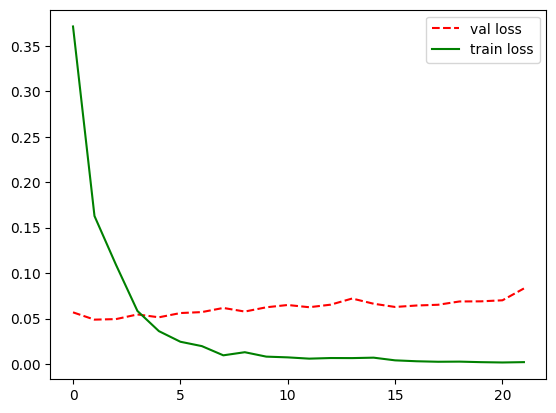

In [26]:
#Graphs of loss function changes
plt.plot(loss_val_arr, "r--", label="val loss")
plt.plot(loss_train_arr, "g", label="train loss")
plt.legend()
plt.show()

In [27]:
torch.save(model.state_dict(), 'hotdogs_resnet18_SGD_earlystop.pth')

In [28]:
test_hotdog_images = []
test_not_hotdog_images = []
test_hotdog_path = os.path.join(test_data_path, 'hotdog')
test_not_hotdog_path = os.path.join(test_data_path, 'nothotdog')

# Model testing

In [29]:
for image_path in os.listdir(test_hotdog_path):
    test_hotdog_images.append(cv2.cvtColor(cv2.imread(os.path.join(test_hotdog_path, image_path)), cv2.COLOR_BGR2RGB))
for image_path in os.listdir(test_not_hotdog_path):
    test_not_hotdog_images.append(cv2.cvtColor(cv2.imread(os.path.join(test_not_hotdog_path, image_path)), cv2.COLOR_BGR2RGB))
test_data = [(transform_val(image), 1) for image in test_hotdog_images]
test_data.extend([(transform_val(image), 0) for image in test_not_hotdog_images])

c:\Users\ivan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [30]:
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [31]:
sum_of_accuracy = 0.0
sum_of_precision = 0.0
sum_of_recall = 0.0
sum_of_f1_score = 0.0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        torch.cuda.empty_cache()
        images.to(device)
        labels.to(device)
        if device == 'cuda:0':
            images, labels = images.cuda(), labels.cuda()
        output = model(images)
        _, predicted = torch.max(output, 1)
        conf_matrix = confusion_matrix(labels.cpu(), predicted.cpu())
        TP = conf_matrix[1][1]
        TN = conf_matrix[0][0]
        FP = conf_matrix[0][1]
        FN = conf_matrix[1][0]

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP) if TP + FP != 0 else 0
        recall = TP / (TP + FN) if TP + FN != 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0
        
        sum_of_accuracy += accuracy
        sum_of_precision += precision
        sum_of_recall += recall
        sum_of_f1_score += f1_score
        print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1_score: {f1_score}')
        
    avg_accuracy = sum_of_accuracy / len(test_loader)
    avg_precision = sum_of_precision / len(test_loader)
    avg_recall = sum_of_recall / len(test_loader)
    avg_f1 = sum_of_f1_score / len(test_loader)
    print(f'\n\nAverage Accuracy: {avg_accuracy}, Average Precision: {avg_precision}, Average Recall: {avg_recall}, Average F1-score: {avg_f1}')

Accuracy: 0.90625, Precision: 0.9411764705882353, Recall: 0.8888888888888888, F1_score: 0.9142857142857143
Accuracy: 0.90625, Precision: 0.9375, Recall: 0.8823529411764706, F1_score: 0.9090909090909091
Accuracy: 0.96875, Precision: 1.0, Recall: 0.9545454545454546, F1_score: 0.9767441860465117
Accuracy: 0.96875, Precision: 0.9230769230769231, Recall: 1.0, F1_score: 0.9600000000000001
Accuracy: 0.9375, Precision: 0.9333333333333333, Recall: 0.9333333333333333, F1_score: 0.9333333333333333
Accuracy: 0.9375, Precision: 0.9333333333333333, Recall: 0.9333333333333333, F1_score: 0.9333333333333333
Accuracy: 0.875, Precision: 0.9090909090909091, Recall: 0.7692307692307693, F1_score: 0.8333333333333333
Accuracy: 0.90625, Precision: 0.875, Recall: 0.9333333333333333, F1_score: 0.9032258064516129
Accuracy: 0.875, Precision: 0.7777777777777778, Recall: 1.0, F1_score: 0.8750000000000001
Accuracy: 0.9375, Precision: 0.9375, Recall: 0.9375, F1_score: 0.9375
Accuracy: 0.875, Precision: 0.8461538461538